In [1]:
import pandas as pd
import geopandas as gpd
import maup
import time
from maup import smart_repair
from gerrychain import Graph

maup.progress.enabled = True

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# state = Wyoming
state_ab = "wy"

## Data
1. Download all the data in directory "tn_data"
2. Extract them all

In [5]:
data_folder = state_ab + "_data/"
population1_data = "./{}{}_pl2020_b/{}_pl2020_p1_b.shp".format(data_folder, state_ab, state_ab)
population2_data = "./{}{}_pl2020_b/{}_pl2020_p2_b.shp".format(data_folder, state_ab, state_ab)
vap_data =  "./{}{}_pl2020_b/{}_pl2020_p4_b.shp".format(data_folder, state_ab, state_ab)
vest20_data = "./{}{}_vest_20/{}_vest_20.shp".format(data_folder, state_ab, state_ab)
vest18_data = "./{}{}_vest_18/{}_vest_18.shp".format(data_folder, state_ab, state_ab)
vest16_data = "./{}{}_vest_16/{}_vest_16.shp".format(data_folder, state_ab, state_ab)
send_data = "./{}{}_sldu_adopted_2022/HB0100_HEA0062_SDFinal_20220314.shp".format(data_folder, state_ab)
hdist_data = "./{}{}_sldl_adopted_2022/HB0100_HEA0062_HDFinal_20220314.shp".format(data_folder, state_ab)

In [6]:
def do_smart_repair(df):
    # change it to the UTM it needs for smart_repair
    df = df.to_crs(df.estimate_utm_crs())
    df = smart_repair(df)
    
    # check maup doctor again to see if smart repair works
    if maup.doctor(df) == True:
        # change it back to this UTM for this data
        df = df.to_crs('EPSG:4269')
    else:
        df = df.to_crs('EPSG:4269')
        raise Exception('maup.doctor failed')
    
    return df

In [7]:
def add_district(dist_df, dist_name, election_df, col_name):
    election_df = election_df.to_crs('EPSG:4269')
    dist_df = dist_df.to_crs('EPSG:4269')
    # check if it needs to be smart_repair
    if maup.doctor(dist_df) != True:
        dist_df = do_smart_repair(dist_df)

    election_df = gpd.GeoDataFrame(election_df, crs="EPSG:4269")

    # assign the pricincts
    precincts_to_district_assignment = maup.assign(election_df.geometry, dist_df.geometry)
    election_df[dist_name] = precincts_to_district_assignment
    for precinct_index in range(len(election_df)):
        election_df.at[precinct_index, dist_name] = dist_df.at[election_df.at[precinct_index, dist_name], col_name]

    return election_df

In [8]:
def rename(original, year):
    party = original[6]
    if party == 'R' or party == 'D':
        return original[3:6] + year + original[6]
    else:
        return original[3:6] + year + 'O'

In [9]:
pop_col = ['TOTPOP', 'HISP', 'NH_WHITE', 'NH_BLACK', 'NH_AMIN', 'NH_ASIAN', 'NH_NHPI', 'NH_OTHER', 'NH_2MORE', 'H_WHITE', 'H_BLACK', 'H_AMIN', 'H_ASIAN', 'H_NHPI', 'H_OTHER', 'H_2MORE', 'VAP', 'HVAP', 'WVAP', 'BVAP', 'AMINVAP', 'ASIANVAP', 'NHPIVAP', 'OTHERVAP', '2MOREVAP']

In [10]:
def check_population(population, df):
    pop_check = pd.DataFrame({
        'pop_col': pop_col,
        'population_df': population[pop_col].sum(), 
        'vest_base': df[pop_col].sum(),
        'equal': [x == y for x, y in zip(population[pop_col].sum(), df[pop_col].sum())]
    })
    if pop_check['equal'].mean() < 1:
        print(pop_check)
        raise Exception("population doesn't agree")

    else:
        print("population agrees")

In [11]:

def add_vest(vest, df, year, population, start_col):
    df = df.to_crs('EPSG:4269')
    vest = vest.to_crs('EPSG:4269')
     # check if it needs to be smart_repair
    if maup.doctor(vest) != True:
        vest = do_smart_repair(vest)
    
    # rename the columns
    original_col = vest.columns[start_col:-1]
    new_col = [rename(i, year) for i in original_col]
    rename_dict = dict(zip(original_col, new_col))
    vest = vest.rename(columns=rename_dict)
    vest = vest.groupby(level=0, axis=1).sum() # combine all the other party's vote into columns with sufix "O"
    col_name = list(set(new_col))
    col_name.sort()
    
    # make the blocks from precincts by weight
    vest = gpd.GeoDataFrame(vest, crs="EPSG:4269")
    election_in_block = population[["VAP", 'geometry']] # population_df is in block scale
    blocks_to_precincts_assignment = maup.assign(election_in_block.geometry, vest.geometry)
    weights = election_in_block["VAP"] / blocks_to_precincts_assignment.map(election_in_block["VAP"].groupby(blocks_to_precincts_assignment).sum())
    weights = weights.fillna(0)
    prorated = maup.prorate(blocks_to_precincts_assignment, vest[col_name], weights)
    election_in_block[col_name] = prorated
    
    # assign blocks to precincts
    election_in_block = gpd.GeoDataFrame(election_in_block, crs="EPSG:4269")
    df = gpd.GeoDataFrame(df, crs="EPSG:4269")
    block_to_pricinct_assginment = maup.assign(election_in_block.geometry, df.geometry)
    df[col_name] = election_in_block[col_name].groupby(block_to_pricinct_assginment).sum()
    df = df.groupby(level=0, axis=1).sum()
    df = gpd.GeoDataFrame(df, crs = "EPSG:4269")
    # check if population agrees
    check_population(population, df)
    
    return df

### Read the census data

In [13]:
population1_df = gpd.read_file(population1_data)
population2_df = gpd.read_file(population2_data)
vap_df = gpd.read_file(vap_data)

In [14]:
population2_df = population2_df.drop(columns=['SUMLEV', 'LOGRECNO', 'GEOID', 'COUNTY', 'geometry'])
vap_df = vap_df.drop(columns=['SUMLEV', 'LOGRECNO', 'GEOID', 'COUNTY', 'geometry'])

In [15]:
population_df = pd.merge(population1_df, population2_df, on='GEOID20')
population_df = pd.merge(population_df, vap_df, on='GEOID20')

In [16]:
maup.doctor(population_df)

100%|███████████████████████████████████| 53769/53769 [00:26<00:00, 2058.48it/s]


True

In [17]:
population_df['H_WHITE'] = population_df.apply(lambda t: t['P0010003'] - t['P0020005'], 1)
population_df['H_BLACK'] = population_df.apply(lambda t: t['P0010004'] - t['P0020006'], 1)
population_df['H_AMIN'] = population_df.apply(lambda t: t['P0010005'] - t['P0020007'], 1)
population_df['H_ASIAN'] = population_df.apply(lambda t: t['P0010006'] - t['P0020008'], 1)
population_df['H_NHPI'] = population_df.apply(lambda t: t['P0010007'] - t['P0020009'], 1)
population_df['H_OTHER'] = population_df.apply(lambda t: t['P0010008'] - t['P0020010'], 1)
population_df['H_2MORE'] = population_df.apply(lambda t: t['P0010009'] - t['P0020011'], 1)

In [18]:
rename_dict = {'P0020001': 'TOTPOP', 'P0020002': 'HISP', 'P0020005': 'NH_WHITE', 'P0020006': 'NH_BLACK', 'P0020007': 'NH_AMIN',
                    'P0020008': 'NH_ASIAN', 'P0020009': 'NH_NHPI', 'P0020010': 'NH_OTHER', 'P0020011': 'NH_2MORE',
                    'P0040001': 'VAP', 'P0040002': 'HVAP', 'P0040005': 'WVAP', 'P0040006': 'BVAP', 'P0040007': 'AMINVAP',
                                        'P0040008': 'ASIANVAP', 'P0040009': 'NHPIVAP', 'P0040010': 'OTHERVAP', 'P0040011': '2MOREVAP'}

In [19]:
population_df.rename(columns=rename_dict, inplace = True)

## Read the vest 20 data

Now using it as a "base pricinct"

In [21]:
def add_vest_base(vest, start_col, year):
    original_col = vest.columns[start_col:-1]
    new_col = [rename(i, year) for i in original_col]
    rename_dict = dict(zip(original_col, new_col))
    vest = vest.rename(columns=rename_dict)
    vest = vest.groupby(level=0, axis=1).sum()
    vest = gpd.GeoDataFrame(vest, crs="EPSG:4269")
    
    return vest

## Check if vest20 can be used as base

In [23]:
vest20 = gpd.read_file(vest20_data)
if maup.doctor(vest20) != True:
    vest20 = do_smart_repair(vest20)

100%|████████████████████████████████████████| 481/481 [00:00<00:00, 671.43it/s]


There are 51 overlaps.
There are 791 holes.
Snapping all geometries to a grid with precision 10^( -5 ) to avoid GEOS errors.
Identifying overlaps...


100%|█████████████████████████████████████| 2534/2534 [00:00<00:00, 3135.98it/s]


Resolving overlaps...
Assigning order 2 pieces...
Filling gaps...


100%|████████████████████████████████████████| 481/481 [00:00<00:00, 690.71it/s]


In [24]:
vest20.columns

Index(['STATEFP20', 'COUNTYFP20', 'VTDST20', 'NAME20', 'G20PRERTRU',
       'G20PREDBID', 'G20PRELJOR', 'G20PREIPIE', 'G20PREOWRI', 'G20USSRLUM',
       'G20USSDDAV', 'G20USSOWRI', 'G20HALRCHE', 'G20HALDBUL', 'G20HALLBRU',
       'G20HALCHAG', 'G20HALOWRI', 'geometry'],
      dtype='object')

In [25]:
start_col = 4
vest_base_data = vest20
year = '20'

In [26]:
vest_base = add_vest_base(vest_base_data, start_col, year)

In [27]:
# vap and population have the same GEOID20
blocks_to_precincts_assignment = maup.assign(population_df.geometry, vest_base.geometry)

100%|████████████████████████████████████████| 481/481 [00:04<00:00, 100.26it/s]


In [28]:
vest_base[pop_col] = population_df[pop_col].groupby(blocks_to_precincts_assignment).sum()

In [29]:
election_df = gpd.GeoDataFrame(vest_base, crs="EPSG:4269")

In [30]:
election_df.columns

Index(['COUNTYFP20', 'HAL20D', 'HAL20O', 'HAL20R', 'NAME20', 'PRE20D',
       'PRE20O', 'PRE20R', 'STATEFP20', 'USS20D', 'USS20O', 'USS20R',
       'VTDST20', 'geometry', 'TOTPOP', 'HISP', 'NH_WHITE', 'NH_BLACK',
       'NH_AMIN', 'NH_ASIAN', 'NH_NHPI', 'NH_OTHER', 'NH_2MORE', 'H_WHITE',
       'H_BLACK', 'H_AMIN', 'H_ASIAN', 'H_NHPI', 'H_OTHER', 'H_2MORE', 'VAP',
       'HVAP', 'WVAP', 'BVAP', 'AMINVAP', 'ASIANVAP', 'NHPIVAP', 'OTHERVAP',
       '2MOREVAP'],
      dtype='object')

## Check if population agrees

In [32]:
pd.DataFrame({
    'pop_col': pop_col,
    'population_df': population_df[pop_col].sum(), 
    'vest_base': vest_base[pop_col].sum(),
    'equal': [x == y for x, y in zip(population_df[pop_col].sum(), vest_base[pop_col].sum())]
})

,pop_col,population_df,vest_base,equal
TOTPOP,TOTPOP,576851,576851,True
HISP,HISP,59046,59046,True
NH_WHITE,NH_WHITE,469664,469664,True
NH_BLACK,NH_BLACK,4735,4735,True
NH_AMIN,NH_AMIN,11781,11781,True
NH_ASIAN,NH_ASIAN,5037,5037,True
NH_NHPI,NH_NHPI,489,489,True
NH_OTHER,NH_OTHER,2425,2425,True
NH_2MORE,NH_2MORE,23674,23674,True
H_WHITE,H_WHITE,18710,18710,True


## Add more vest data

In [34]:
vest18 = gpd.read_file(vest18_data)
vest16 = gpd.read_file(vest16_data)

In [35]:
vest18.columns

Index(['STATEFP20', 'COUNTYFP20', 'VTDST20', 'NAME20', 'G18USSRBAR',
       'G18USSDTRA', 'G18USSLPOR', 'G18USSOWRI', 'G18HALRCHE', 'G18HALDHUN',
       'G18HALLBRU', 'G18HALCCUM', 'G18HALOWRI', 'G18GOVRGOR', 'G18GOVDTHR',
       'G18GOVLSTR', 'G18GOVCRAM', 'G18GOVOWRI', 'G18SOSRBUC', 'G18SOSDBYR',
       'G18SOSLCAR', 'G18SOSOWRI', 'G18AUDRRAC', 'G18AUDDDOC', 'G18AUDOWRI',
       'G18TRERMEI', 'G18TREDLOW', 'G18TREOWRI', 'G18SPIRBAL', 'G18SPIOWRI',
       'geometry'],
      dtype='object')

In [36]:
vest16.columns

Index(['STATEFP20', 'COUNTYFP20', 'VTDST20', 'NAME20', 'G16PRERTRU',
       'G16PREDCLI', 'G16PRELJOH', 'G16PRECCAS', 'G16PREIFUE', 'G16PREGSTE',
       'G16PREOWRI', 'G16HALRCHE', 'G16HALDGRE', 'G16HALLSTR', 'G16HALCCUM',
       'G16HALOWRI', 'geometry'],
      dtype='object')

In [37]:
# check the result here
election_df = add_vest(vest18, election_df, '18', population_df, start_col)

100%|████████████████████████████████████████| 483/483 [00:00<00:00, 682.84it/s]


There are 51 overlaps.
There are 798 holes.
Snapping all geometries to a grid with precision 10^( -5 ) to avoid GEOS errors.
Identifying overlaps...


100%|█████████████████████████████████████| 2538/2538 [00:00<00:00, 3353.76it/s]


Resolving overlaps...
Assigning order 2 pieces...
Filling gaps...


100%|████████████████████████████████████████| 481/481 [00:04<00:00, 103.58it/s]


population agrees


In [38]:
election_df.columns

Index(['2MOREVAP', 'AMINVAP', 'ASIANVAP', 'AUD18D', 'AUD18O', 'AUD18R', 'BVAP',
       'COUNTYFP20', 'GOV18D', 'GOV18O', 'GOV18R', 'HAL18D', 'HAL18O',
       'HAL18R', 'HAL20D', 'HAL20O', 'HAL20R', 'HISP', 'HVAP', 'H_2MORE',
       'H_AMIN', 'H_ASIAN', 'H_BLACK', 'H_NHPI', 'H_OTHER', 'H_WHITE',
       'NAME20', 'NHPIVAP', 'NH_2MORE', 'NH_AMIN', 'NH_ASIAN', 'NH_BLACK',
       'NH_NHPI', 'NH_OTHER', 'NH_WHITE', 'OTHERVAP', 'PRE20D', 'PRE20O',
       'PRE20R', 'SOS18D', 'SOS18O', 'SOS18R', 'SPI18O', 'SPI18R', 'STATEFP20',
       'TOTPOP', 'TRE18D', 'TRE18O', 'TRE18R', 'USS18D', 'USS18O', 'USS18R',
       'USS20D', 'USS20O', 'USS20R', 'VAP', 'VTDST20', 'WVAP', 'geometry'],
      dtype='object')

In [39]:
election_df = add_vest(vest16, election_df, '16', population_df, start_col)

100%|████████████████████████████████████████| 483/483 [00:00<00:00, 686.76it/s]


There are 52 overlaps.
There are 804 holes.
Snapping all geometries to a grid with precision 10^( -5 ) to avoid GEOS errors.
Identifying overlaps...


100%|█████████████████████████████████████| 2536/2536 [00:00<00:00, 3378.02it/s]


Resolving overlaps...
Assigning order 2 pieces...
Filling gaps...


100%|████████████████████████████████████████| 481/481 [00:04<00:00, 103.54it/s]


population agrees


##  Add the district data

In [41]:
send = gpd.read_file(send_data)
hdist = gpd.read_file(hdist_data)

In [42]:
send.head()

,ID,AREA,DISTRICT,MEMBERS,LOCKED,NAME,POPULATION,WHITE,BLACK,AMINDIAN,...,F18_NP_HWN,F18_AP_OTH,F18_NP_OTH,F18_1_RACE,F18_2_RACE,F18_2_RAC1,F18_3_RACE,F18_4_RACE,F18_5_RACE,geometry
0,2,4296.627441,10,1.0,None,None,18519,15660,184,182,...,14871,1051,13844,13802,1093,1047,42,4,0,"POLYGON ((-105.63097 40.99712, -105.63586 40.9..."
1,3,16349.305664,11,1.0,None,None,18135,14755,173,246,...,13988,1605,12415,12925,1095,1063,31,1,0,"POLYGON ((-106.09539 41.39500, -106.10228 41.3..."
2,6,10247.032227,14,1.0,None,None,18189,16225,39,152,...,13672,812,12904,13018,698,684,11,3,0,"POLYGON ((-109.42549 41.49125, -109.42503 41.4..."
3,13,8422.623047,20,1.0,None,None,17793,15752,39,215,...,13747,829,12950,13003,776,728,41,7,0,"POLYGON ((-109.51227 43.93913, -109.51227 43.9..."
4,18,2738.210205,25,1.0,None,None,19167,11122,109,6429,...,13960,444,13549,13256,737,678,50,7,2,"POLYGON ((-108.44054 42.26340, -108.45797 42.2..."


In [43]:
election_df = add_district(send, "SEND", election_df, "DISTRICT")

100%|███████████████████████████████████████████| 31/31 [00:00<00:00, 54.77it/s]


In [44]:
hdist.head()

,ID,AREA,DISTRICT,MEMBERS,LOCKED,NAME,POPULATION,WHITE,BLACK,AMINDIAN,...,F18_NP_HWN,F18_AP_OTH,F18_NP_OTH,F18_1_RACE,F18_2_RACE,F18_2_RAC1,F18_3_RACE,F18_4_RACE,F18_5_RACE,geometry
0,6,2704.081055,14,1.0,None,None,9278,7855,102,95,...,7513,425,7097,7013,509,495,13,1,0,"POLYGON ((-106.07147 41.54563, -106.07152 41.5..."
1,7,2456.038330,15,1.0,None,None,9091,7093,126,165,...,6895,955,5952,6297,610,598,11,1,0,"POLYGON ((-106.94097 42.43335, -106.94095 42.4..."
2,10,4891.289551,18,1.0,None,None,8886,7900,21,94,...,6648,403,6270,6326,347,338,6,3,0,"POLYGON ((-109.42549 41.49125, -109.42503 41.4..."
3,13,5355.742676,20,1.0,None,None,9303,8325,18,58,...,7024,409,6634,6692,351,346,5,0,0,"POLYGON ((-109.04386 42.26368, -109.04579 42.2..."
4,17,3618.739258,24,1.0,None,None,9031,8299,17,52,...,7328,229,7104,7002,331,320,9,2,0,"POLYGON ((-109.04632 44.52449, -109.04635 44.5..."


In [45]:
hdist = hdist.to_crs("EPSG:4269")
election_df = add_district(hdist, "HDIST", election_df, "DISTRICT")

100%|███████████████████████████████████████████| 62/62 [00:00<00:00, 82.16it/s]


In [46]:
maup.doctor(election_df)

100%|████████████████████████████████████████| 481/481 [00:00<00:00, 592.80it/s]


True

### Put the base precinct year after the precinct information column

In [48]:
base_columns = {}
if 'COUNTYFP' + year not in election_df.columns:
    base_columns = {
        'STATEFP':'STATEFP'+year,
        'COUNTYFP':'COUNTYFP'+year,
        'VTDST':'VTDST'+year,
        'NAME':'NAME'+year}
election_df.rename(columns=base_columns, inplace = True)

In [49]:
election_df.columns

Index(['2MOREVAP', 'AMINVAP', 'ASIANVAP', 'AUD18D', 'AUD18O', 'AUD18R', 'BVAP',
       'COUNTYFP20', 'GOV18D', 'GOV18O', 'GOV18R', 'HAL16D', 'HAL16O',
       'HAL16R', 'HAL18D', 'HAL18O', 'HAL18R', 'HAL20D', 'HAL20O', 'HAL20R',
       'HISP', 'HVAP', 'H_2MORE', 'H_AMIN', 'H_ASIAN', 'H_BLACK', 'H_NHPI',
       'H_OTHER', 'H_WHITE', 'NAME20', 'NHPIVAP', 'NH_2MORE', 'NH_AMIN',
       'NH_ASIAN', 'NH_BLACK', 'NH_NHPI', 'NH_OTHER', 'NH_WHITE', 'OTHERVAP',
       'PRE16D', 'PRE16O', 'PRE16R', 'PRE20D', 'PRE20O', 'PRE20R', 'SOS18D',
       'SOS18O', 'SOS18R', 'SPI18O', 'SPI18R', 'STATEFP20', 'TOTPOP', 'TRE18D',
       'TRE18O', 'TRE18R', 'USS18D', 'USS18O', 'USS18R', 'USS20D', 'USS20O',
       'USS20R', 'VAP', 'VTDST20', 'WVAP', 'geometry', 'SEND', 'HDIST'],
      dtype='object')

In [50]:
# reorder the columns
fixed_columns = [
    'STATEFP'+year,
    'COUNTYFP'+year,
    'VTDST'+year,
    'NAME'+year,
    'SEND',
    'HDIST',
    'TOTPOP',
    'NH_2MORE',
    'NH_AMIN',
    'NH_ASIAN',
    'NH_BLACK',
    'NH_NHPI',
    'NH_OTHER',
    'NH_WHITE',
    'HISP',
    'H_AMIN',
    'H_ASIAN',
    'H_BLACK',
    'H_NHPI',
    'H_OTHER',
    'H_WHITE',
    'H_2MORE',
    'VAP',
    'HVAP',
    'WVAP',
    'BVAP',
    'AMINVAP',
    'ASIANVAP',
    'NHPIVAP',
    'OTHERVAP',
    '2MOREVAP']

election_columns = [col for col in election_df.columns if col not in fixed_columns]
final_col = fixed_columns + election_columns
election_df = election_df[final_col]

In [51]:
import os

# store the result in directory "il"
directory = "./{}".format(state_ab)
if not os.path.exists(directory):
    os.makedirs(directory)

shapefile_path = "./{}/{}.shp".format(state_ab, state_ab)
geojson_path = './{}/{}.geojson'.format(state_ab, state_ab)
json_path = "./{}/{}.json".format(state_ab, state_ab)

# Check if the shapefile or geojson file already exists
if os.path.exists(shapefile_path):
    os.remove(shapefile_path)
if os.path.exists(geojson_path):
    os.remove(geojson_path)

election_df.to_file(shapefile_path)
election_df.to_file(geojson_path, driver='GeoJSON')

# Only do once to build json and read from file when generating ensembles
graph = Graph.from_file(shapefile_path, ignore_errors=True)
graph.to_json(json_path)

<Axes: >

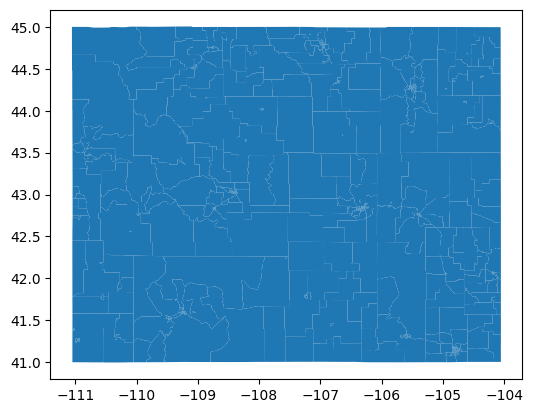

In [52]:
shapefile_path = "./{}/{}.shp".format(state_ab, state_ab)
shape=gpd.read_file(shapefile_path)
shape.plot()